In [1]:
import visual_behavior.database as db
import visual_behavior.utilities as vbu
from visual_behavior.data_access import loading
from visual_behavior.translator.foraging2 import data_to_change_detection_core
import seaborn as sns
from scipy import signal
from scipy.signal import medfilt

import allensdk.brain_observatory.behavior.running_processing as rp

/home/dougo/Code/AllenSDK/allensdk/brain_observatory/behavior/behavior_ophys_api/behavior_ophys_nwb_api.py:9: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
%widescreen
%matplotlib notebook

In [3]:
experiment_id = 852689577
session = loading.get_ophys_dataset(experiment_id)

In [5]:
running_df = session.running_data_df.reset_index().rename(columns={'timestamps':'time'})
filename = '/home/dougo/2020.06.26_running_data_oeid_{}.csv'.format(experiment_id)
running_df[['time','v_sig','v_in']].to_csv(filename,index=False)
print(filename)

/home/dougo/2020.06.26_running_data_oeid_852689577.csv


## function definitions

In [4]:
def load_running_df(bsid):
    print('loading running data for bsid {}'.format(bsid))
    pkl_path = db.get_pkl_path(int(bsid))
    print('pkl_path = {}'.format(pkl_path))
    data = pd.read_pickle(pkl_path)
    core_data = data_to_change_detection_core(data)
    return core_data['running']


def identify_wraps(row,lower_threshold=1.5,upper_threshold=3.5):
    
    if row['v_sig'] < lower_threshold and row['v_sig_last'] > upper_threshold:
        return 1 # positive wrap
    elif row['v_sig'] > upper_threshold and row['v_sig_last'] < lower_threshold:
        return -1 # negative wrap
    else:
        return 0

def calculate_wrap_corrected_diff(row, max_diff = 1, nan_transitions=False):
    if row['wrap_ID'] == 1:
        # unrwap the current value, subtract the last valueif nan_transitions:
        if nan_transitions:
            diff = np.nan
        else:
            diff = (row['v_sig'] + row['v_in']) - row['v_sig_last']
    elif row['wrap_ID'] == -1:
        # unwrap the last value, subtract it from the current value
        if nan_transitions:
            diff = np.nan
        else:
            diff = row['v_sig'] - (row['v_sig_last'] + row['v_in'])
    else:
        diff = row['v_sig'] - row['v_sig_last']
        
    if np.abs(diff) > max_diff:
        return row['v_sig_diff_rolling_median']
    else:
        return diff


def clean_voltage_signal(df_in,nan_transitions=True):
    df = df_in.copy()
    df['v_sig_last'] = df['v_sig'].shift()
    df['v_sig_diff'] = df['v_sig'] - df['v_sig_last']
    df['v_sig_diff_last'] = df['v_sig_diff'].shift()
    df['v_sig_diff_rolling_median'] = df['v_sig_diff'].rolling(window=5,min_periods=0,center=True).median()
    
    # this takes ~1.5 seconds
    df['wrap_ID'] = df.apply(identify_wraps,axis=1)
    
    df['dx_drop_wraps'] = df['dx']
    df.loc[df[df['wrap_ID'] != 0].index,'dx_drop_wraps'] = np.nan
    
    df['v_sig_diff_uncorrected'] = df['v_sig'] - df['v_sig_last']
    
    # this takes ~ 3 seconds
    df['v_sig_diff'] = df.apply(calculate_wrap_corrected_diff,axis=1,nan_transitions=nan_transitions)
    
    #this should be the equivalent to dx
    df['dx_recalc'] = df['v_sig_diff']/df['v_in']*360

    df['delta_theta'] = df['v_sig_diff']/df['v_in']*2*np.pi
    df['dt'] = df['time'].diff().shift() # the shift is necessary to realign the time
    wheel_diameter = 6.5 * 2.54  # 6.5" wheel diameter
    running_radius = 0.5 * (2.0 * wheel_diameter / 3.0)  # assume the animal runs at 2/3 the distance from the wheel center
    df['speed_cm_s_raw'] = df['delta_theta']/df['dt'] * running_radius
    
    b, a = signal.butter(3, 0.2)
    df['speed_cm_s_butterworth_filtered'] = signal.filtfilt(b, a, df['speed_cm_s_raw'].fillna(0))
    
    df['speed_original'] = df['speed']
    
    for center in [True,False]:
        for kernel_size in [3,5,7,9,13,15,17,19]:
            df['speed_medfilt_kernel={}_centered={}'.format(kernel_size,center)] = rp.deg_to_dist(
                rp.calc_deriv(
                    np.cumsum(df['dx_drop_wraps'].rolling(
                        window=kernel_size,
                        center=center,
                        min_periods=0
                    ).median()),
                    df['time'],
                )
            )
    
    return df   

In [5]:
def make_plot(df_in,speed_variants_to_plot,color_palette,x_lim=None):
    
    if x_lim is not None:
        df = df_in.query('time >= {} and time <= {}'.format(x_lim[0], x_lim[1]))
    else:
        df = df_in
        
    fig,ax=plt.subplots(4,1,sharex=True,figsize=(15,15))

    ax[0].plot(
        df['time'][1:],
        np.diff(df['time']),
        '.-k'
    )
    ax[0].set_ylabel('delta t (s)')
    ax[0].set_title('dt')
    # ax[0].set_ylim(0.015,0.018)

    ax[1].plot(
        df['time'],
        df['v_sig'],
        '.-'
    )
    ax[1].plot(
        df['time'],
        df['v_in'],
        '.-'
    )
    ax[1].set_ylim(-0.5,5.5)
    ax[1].set_ylabel('V')
    ax[1].set_title('voltage signals')
    ax[1].legend(['v_sig','v_in'])

    ax[2].plot(
        df['time'],
        df['dx'],
        '-r'
    )

    ax[2].set_ylabel('deg/s')
    ax[2].set_title('dx (should be called d_theta)')
    ax[2].set_ylim(-2,15)
    
    for ii,speed_variant in enumerate(speed_variants_to_plot):
        ax[3].plot(
            df['time'],
            df[speed_variant],
            color=color_palette[ii],
            linewidth=2,
            alpha=0.75,
        )
    
    
    ax[3].set_ylim(-3,70)
    ax[3].legend(speed_variants,loc='lower left',fontsize=6)

    ax[3].set_ylabel('speed (cm/s)')
    ax[3].set_title('computed running speed')

    # ax[-1].set_xlim(889.25,892)

    ax[-1].set_xlabel('time (s)')
    fig.tight_layout()
    
    return fig,ax

In [7]:
# running_df_cleaned.query('time>=2923.35 and time <=2924').head()

In [8]:
def make_plot_alternative(df_in,speed_variants_to_plot,color_palette,x_lim=None):
    
    if x_lim is not None:
        df = df_in.query('time >= {} and time <= {}'.format(x_lim[0], x_lim[1]))
    else:
        df = df_in
        
    fig,ax=plt.subplots(5,1,sharex=True,figsize=(15,15))

    ax[0].plot(
        df['time'][1:],
        np.diff(df['time']),
        '.-k'
    )
    ax[0].set_ylabel('delta t (s)')
    ax[0].set_title('dt')
    # ax[0].set_ylim(0.015,0.018)

    ax[1].plot(
        df['time'],
        df['v_sig'],
        '.-'
    )
    ax[1].plot(
        df['time'],
        df['v_in'],
        '.-'
    )
    ax[1].set_ylim(-0.5,5.5)
    ax[1].set_ylabel('V')
    ax[1].set_title('voltage signals')
    ax[1].legend(['v_sig','v_in'])
    
    
    ax[2].plot(
        df['time'],
        df['v_sig_diff']
    )
    ax[2].set_ylabel('V')
    ax[2].set_title('delta V')

    ax[3].plot(
        df['time'],
        df['dx'],
        '-r'
    )
    ax[3].plot(
        df['time'],
        df['dx_recalc'],
        '-',
        color='gray',
    )

    ax[3].set_ylabel('deg/s')
    ax[3].set_title('dx (should be called d_theta)')
#     ax[2].set_ylim(-2,15)
    
    for ii,speed_variant in enumerate(speed_variants_to_plot):
        ax[4].plot(
            df['time'],
            df[speed_variant],
            color=color_palette[ii],
            linewidth=2,
            alpha=0.75,
        )
    
    ax[4].set_ylim(-3,70)
    ax[4].legend(speed_variants,loc='lower left',fontsize=6)

    ax[4].set_ylabel('speed (cm/s)')
    ax[4].set_title('computed running speed')

    # ax[-1].set_xlim(889.25,892)

    ax[-1].set_xlabel('time (s)')
    fig.tight_layout()
    
    return fig,ax

## get all hit change times for this session

In [9]:
hit_change_times = session.trials.query('hit')['change_time']

/home/dougo/Code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/home/dougo/Code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()


## get the running data

In [10]:
running_df = session.running_data_df
running_df_cleaned = clean_voltage_signal(running_df.reset_index().rename(columns={'timestamps':'time'}))

## process it

In [11]:
running_df_cleaned

,time,speed,dx,v_sig,v_in,v_sig_last,v_sig_diff,v_sig_diff_last,v_sig_diff_rolling_median,wrap_ID,dx_drop_wraps,v_sig_diff_uncorrected,dx_recalc,delta_theta,dt,speed_cm_s_raw,speed_cm_s_butterworth_filtered,speed_original,speed_medfilt_kernel=3_centered=True,speed_medfilt_kernel=5_centered=True,speed_medfilt_kernel=7_centered=True,speed_medfilt_kernel=9_centered=True,speed_medfilt_kernel=13_centered=True,speed_medfilt_kernel=15_centered=True,speed_medfilt_kernel=17_centered=True,speed_medfilt_kernel=19_centered=True,speed_medfilt_kernel=3_centered=False,speed_medfilt_kernel=5_centered=False,speed_medfilt_kernel=7_centered=False,speed_medfilt_kernel=9_centered=False,speed_medfilt_kernel=13_centered=False,speed_medfilt_kernel=15_centered=False,speed_medfilt_kernel=17_centered=False,speed_medfilt_kernel=19_centered=False
0,7.314303,25.022575,-47.735771,3.429044,4.989814,NaN,NaN,NaN,0.070416,0,-47.735771,NaN,NaN,NaN,NaN,NaN,-0.035049,25.022575,25.022575,28.430919,25.022575,28.430919,28.430919,27.161435,29.500349,28.757395,-124.112140,-124.112140,-124.112140,-124.112140,-124.112140,-124.112140,-124.112140,-124.112140
1,7.331083,25.082509,4.371402,3.483310,4.980770,3.429044,0.054265,NaN,0.072354,0,4.371402,0.054265,3.922177,0.068455,NaN,NaN,9.771572,25.082509,28.507181,26.786682,26.794845,30.211353,27.861235,28.401552,29.197752,28.425374,-49.484848,-49.484848,-49.484848,-49.484848,-49.484848,-49.484848,-49.484848,-49.484848
2,7.347783,28.586295,5.855837,3.569875,4.988522,3.483310,0.086566,0.054265,0.063309,0,5.855837,0.086566,6.247082,0.109032,0.01678,35.759255,18.288817,28.586295,32.010966,28.586295,30.298631,30.296578,28.484380,29.285735,28.511096,28.511577,28.586295,26.871906,26.871906,26.871906,26.871906,26.871906,26.871906,26.871906
3,7.364463,32.915934,5.562266,3.642229,4.982062,3.569875,0.072354,0.086566,0.072354,0,5.562266,0.072354,5.228213,0.091250,0.01670,30.070452,24.620876,32.915934,32.068644,32.915934,32.068644,27.995663,29.338277,28.562226,28.563191,28.562226,32.068644,26.917235,26.917235,26.917235,26.917235,26.917235,26.917235,26.917235
4,7.381103,32.964086,2.667241,3.684866,4.989814,3.642229,0.042637,0.072354,0.077522,0,2.667241,0.042637,3.076124,0.053689,0.01668,17.713772,28.490911,32.964086,33.212911,32.964086,32.116795,29.758203,28.605474,28.605716,28.605474,27.800539,32.116795,28.679775,26.960232,26.960232,26.960232,26.960232,26.960232,26.960232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269931,4510.604433,0.439994,-0.464628,1.668011,4.978186,1.678347,-0.010336,0.000000,0.005168,0,-0.464628,-0.010336,-0.747469,-0.013046,0.01666,-4.309446,-0.309889,0.439994,0.435710,0.439994,0.435710,0.305996,0.439265,0.440690,0.439265,0.356416,-0.359670,-0.359670,-0.093130,-0.093130,-0.180116,-0.270134,-0.270134,-0.270134
269932,4510.621233,0.445982,0.373735,1.673179,4.978186,1.668011,0.005168,-0.010336,0.000000,0,0.373735,0.005168,0.373735,0.006523,0.01671,2.148275,0.001344,0.445982,1.241362,0.445982,0.837665,0.843672,0.440113,0.444107,0.440113,0.444107,0.445982,0.445982,0.175693,0.175693,-0.001311,-0.001311,-0.180989,-0.180989
269933,4510.637783,1.240996,0.215495,1.679639,4.988522,1.673179,0.006460,0.005168,0.005168,0,0.215495,0.006460,0.466200,0.008137,0.01680,2.665424,0.630840,1.240996,1.240996,1.331216,0.837298,0.843542,0.306713,0.444055,0.439904,0.444055,1.240996,0.446089,-0.090740,0.175641,0.175641,-0.001258,-0.180936,-0.180936
269934,4510.654593,0.615662,-0.339620,1.670595,4.975602,1.679639,-0.009044,0.006460,0.005814,0,-0.339620,-0.009044,-0.654375,-0.011421,0.01655,-3.797799,1.553533,0.615662,0.527042,1.332351,1.333935,0.844678,0.844678,0.309175,0.440064,0.444703,1.242131,0.447224,0.447224,0.175801,0.175801,-0.001097,-0.001097,-0.181101


## create event triggered averages and convert to 'tidy' format to facilitate seaborn plotting

In [12]:
df_all = []
speed_variants = [
    'speed_original',
    'speed_cm_s_raw',
    'speed_cm_s_butterworth_filtered',
    'speed_medfilt_kernel=3_centered=True',
    'speed_medfilt_kernel=5_centered=True',
    'speed_medfilt_kernel=7_centered=True',
    'speed_medfilt_kernel=9_centered=True',
    'speed_medfilt_kernel=3_centered=False',
    'speed_medfilt_kernel=5_centered=False',
    'speed_medfilt_kernel=7_centered=False',
    'speed_medfilt_kernel=9_centered=False',
]
for speed_col in speed_variants:
    etr = vbu.event_triggered_response(
        df = running_df_cleaned,
        parameter = speed_col,
        event_times = hit_change_times
    )
    x_value = 'time'
    y_values = [col for col in etr.columns if col != 'time']
    var_name = 'line'
    value_name = 'value'
    df_melted = pd.melt(
            etr,
            id_vars=[x_value],
            value_vars=y_values,
            var_name='event_name',
            value_name='running_speed'
        )
    df_melted['speed_type'] = speed_col
    df_all.append(df_melted)
df_all = pd.concat(df_all)

### make a color palette, replace the first element with black

In [13]:
color_palette = sns.color_palette("hls", len(speed_variants))
color_palette[0] = (0,0,0)
sns.palplot(color_palette)

<IPython.core.display.Javascript object>

## plot the change triggered average of the different variants of speed (different filtering strategies)

In [14]:
fig,ax=plt.subplots(len(speed_variants)+1,2,figsize=(15,4*(len(speed_variants)+1)),sharex='col',sharey='row')
title_suffixes = ['',' (zoomed in)']
for col in range(2):
    for row,speed_variant in enumerate(speed_variants):

        sns.lineplot(
            data=df_all.query('speed_type == @speed_variant'),
            x='time',
            y='running_speed',
            n_boot=100,
#             ci=None,
            ax=ax[row,col],
            color=color_palette[row],
        )
        ax[row,col].axvline(0)
        ax[row,col].set_title('speed_variant = {}{}'.format(speed_variant,title_suffixes[col]))
        
    # now plot the overlay of all
    row += 1
    if col == 0:
        legend = 'brief'
    else:
        legend = False
        
    sns.lineplot(
        data=df_all,
        x='time',
        y='running_speed',
        hue = 'speed_type',
        alpha=0.75,
        ci=None,
        ax=ax[row,col],
        palette=color_palette,
        legend=legend,
    )
    ax[row,col].axvline(0)
    ax[row,col].set_title('overlay{}'.format(title_suffixes[col]))
    if col == 0:
        plt.legend(loc='upper right')
        plt.setp(ax[row,col].get_legend().get_texts(), fontsize='6')
        
ax[row,0].set_xlim(-3.5,3.5)
ax[row,1].set_xlim(-1,1)

<IPython.core.display.Javascript object>

(-1.0, 1.0)

## look at a short snippet of time (10 seconds seems good) of the different filter variants

In [15]:
running_df_cleaned = clean_voltage_signal(running_df.reset_index().rename(columns={'timestamps':'time'}),nan_transitions=False)

<IPython.core.display.Javascript object>


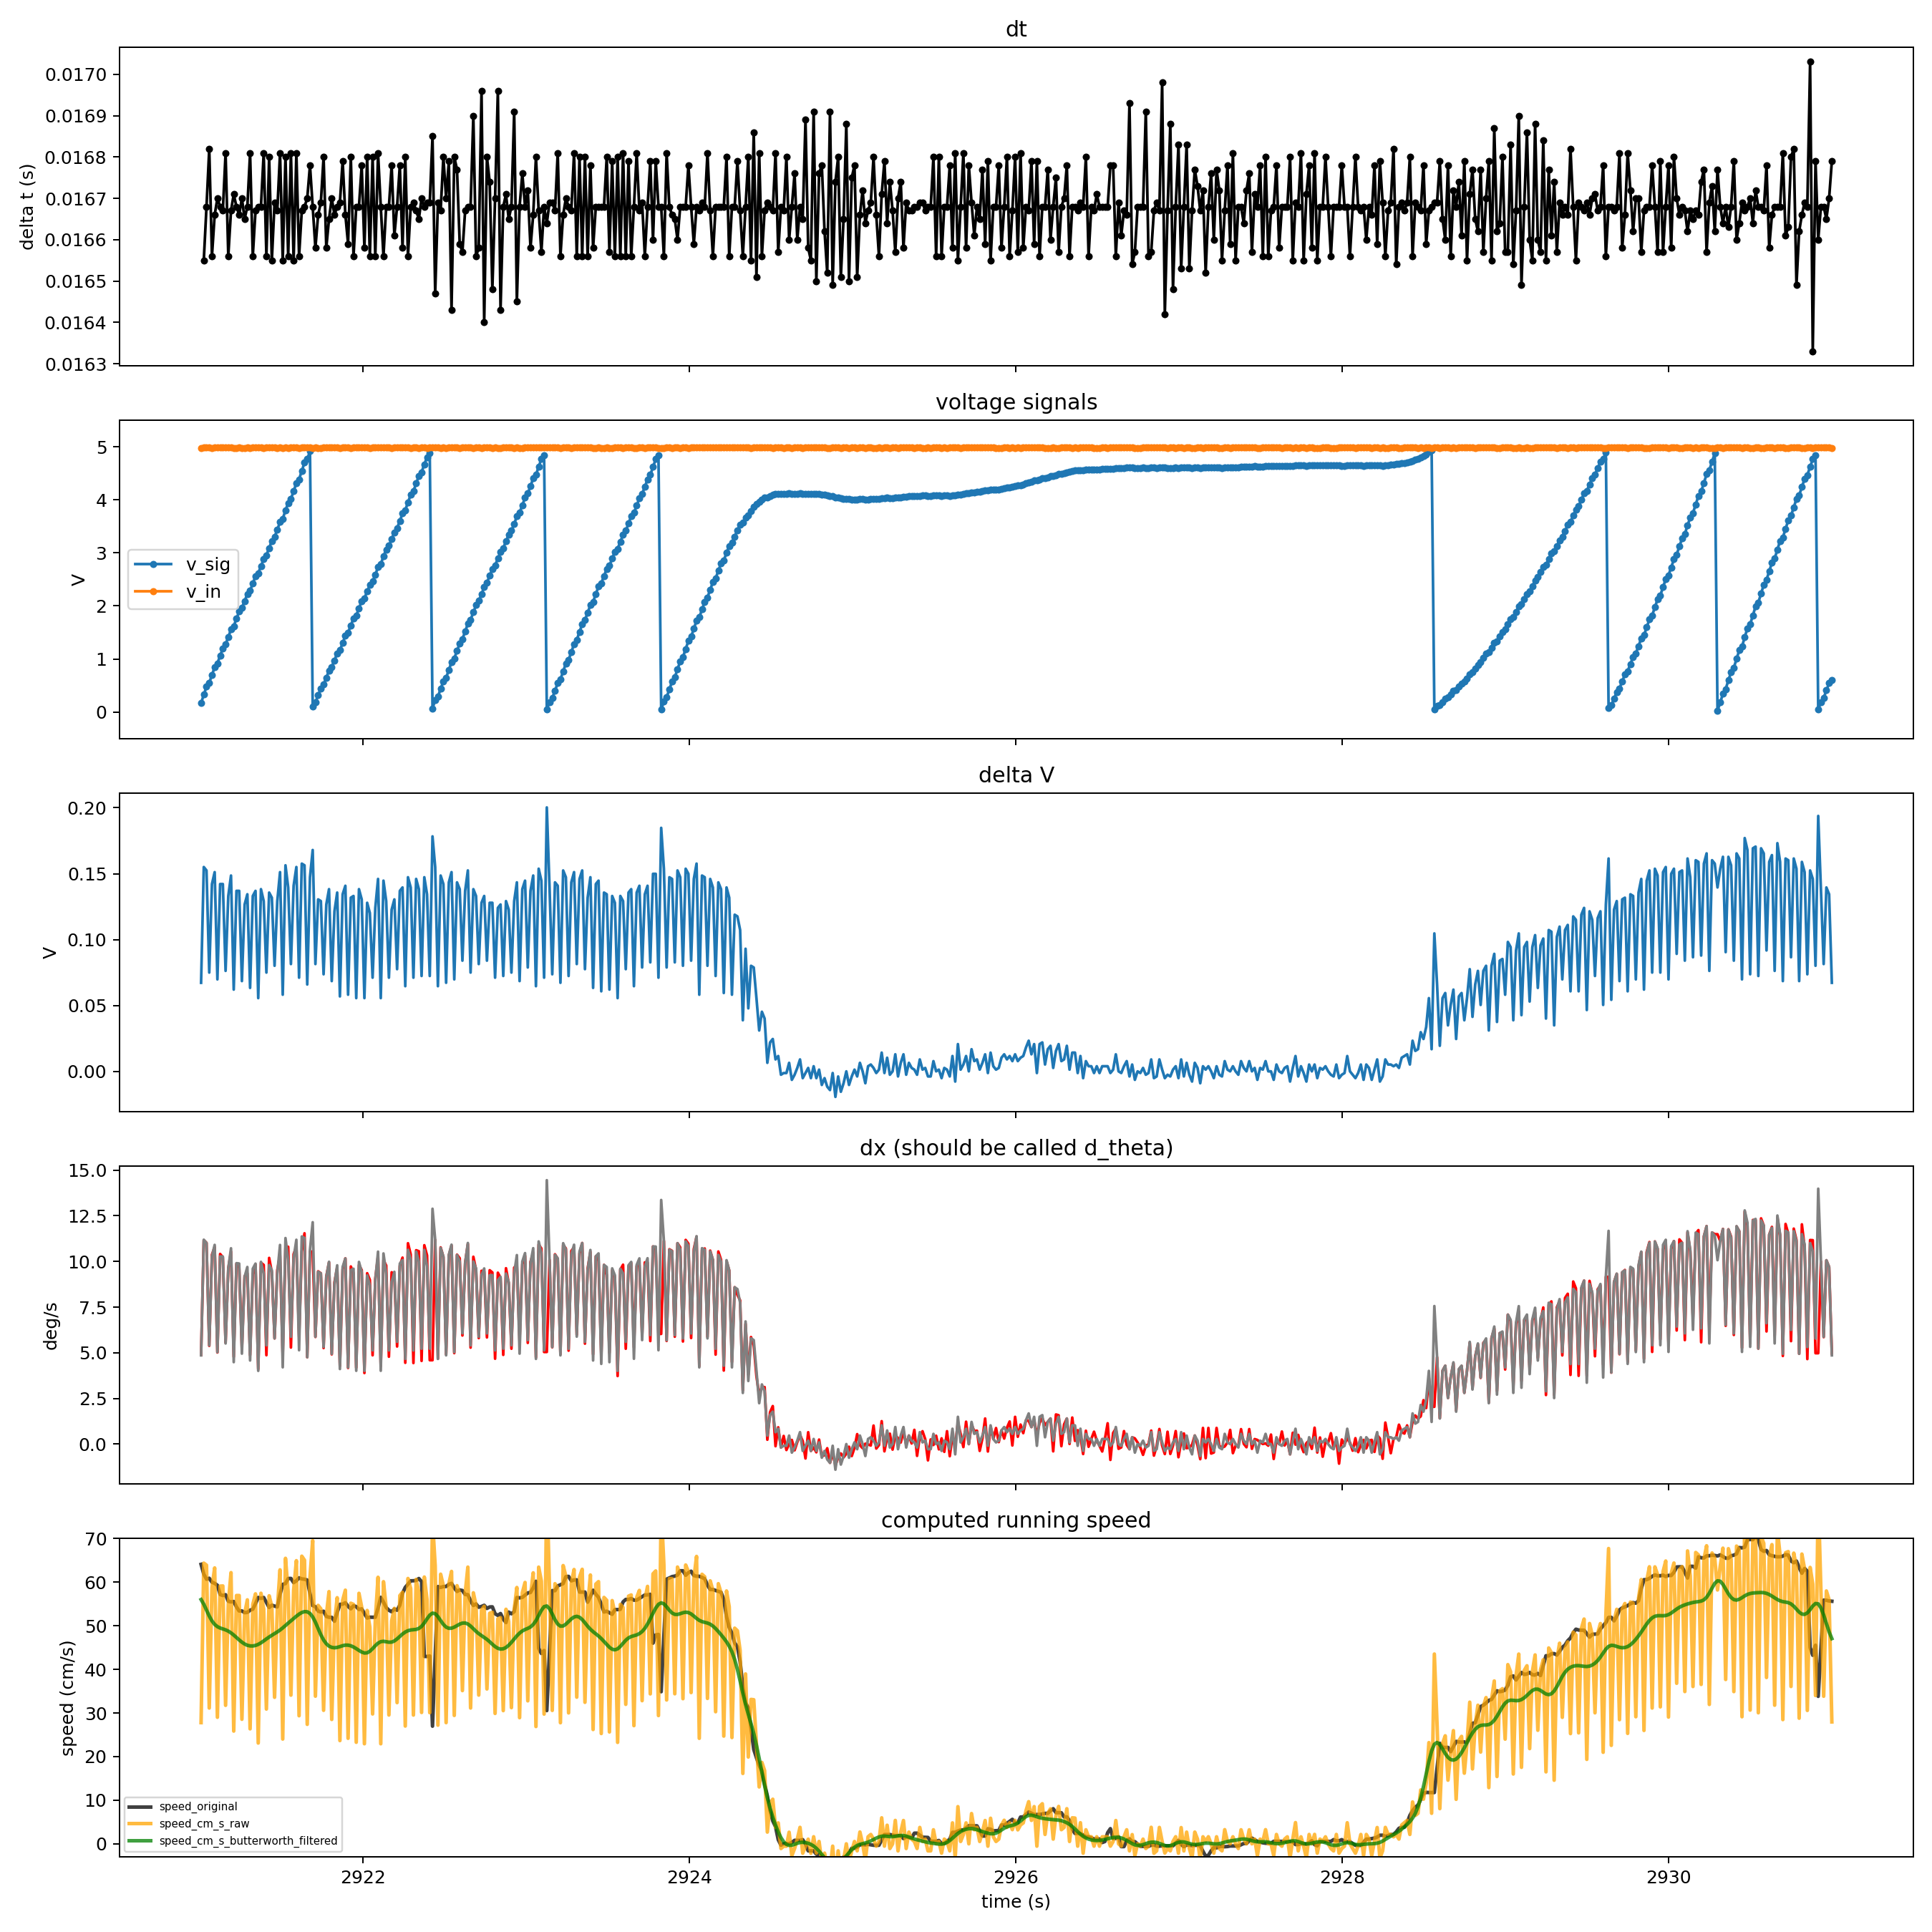

In [18]:
limited_speed_variants = [
    'speed_original',
    'speed_cm_s_raw',
    'speed_cm_s_butterworth_filtered',
]
fig,ax=make_plot_alternative(
    running_df_cleaned,
    limited_speed_variants,
    ['black','orange','green'], 
    x_lim=(2921,2931)
)

In [184]:
df_sample = running_df_cleaned.query('time>=2920 and time <=2940')[['time','v_sig','v_in']].copy()
df_sample.to_csv('/home/dougo/2020.06.26_running_data_sample.csv',index=False)

In [180]:
df_sample['dv'] = df_sample['v_sig'].diff()
df_sample['v_sig_last'] = df_sample['v_sig'].shift()
df_sample['wrap_ID'] = df_sample.apply(identify_wraps,axis=1)
df_sample['v_sig_diff'] = df_sample.apply(calculate_wrap_corrected_diff,axis=1,nan_transitions=False)
df_sample['v_sig_unwrapped'] = np.cumsum(df_sample['v_sig_diff']) + df_sample['v_sig'].iloc[0]
df_sample.head(100)

,time,v_sig,v_in,dv,v_sig_last,wrap_ID,v_sig_diff,v_sig_unwrapped
174594,2920.006553,2.799827,4.987230,NaN,NaN,0,NaN,NaN
174595,2920.023353,2.923862,4.984646,0.124035,2.799827,0,0.124035,2.923862
174596,2920.040033,2.994923,4.976894,0.071062,2.923862,0,0.071062,2.994923
174597,2920.056603,3.126710,4.982062,0.131787,2.994923,0,0.131787,3.126710
174598,2920.073273,3.271417,4.989814,0.144707,3.126710,0,0.144707,3.271417
174599,2920.089963,3.333434,4.978186,0.062017,3.271417,0,0.062017,3.333434
174600,2920.106763,3.487186,4.989814,0.153751,3.333434,0,0.153751,3.487186
174601,2920.123323,3.625433,4.979478,0.138247,3.487186,0,0.138247,3.625433
174602,2920.140003,3.696494,4.991106,0.071062,3.625433,0,0.071062,3.696494
174603,2920.156683,3.834741,4.978186,0.138247,3.696494,0,0.138247,3.834741


<IPython.core.display.Javascript object>


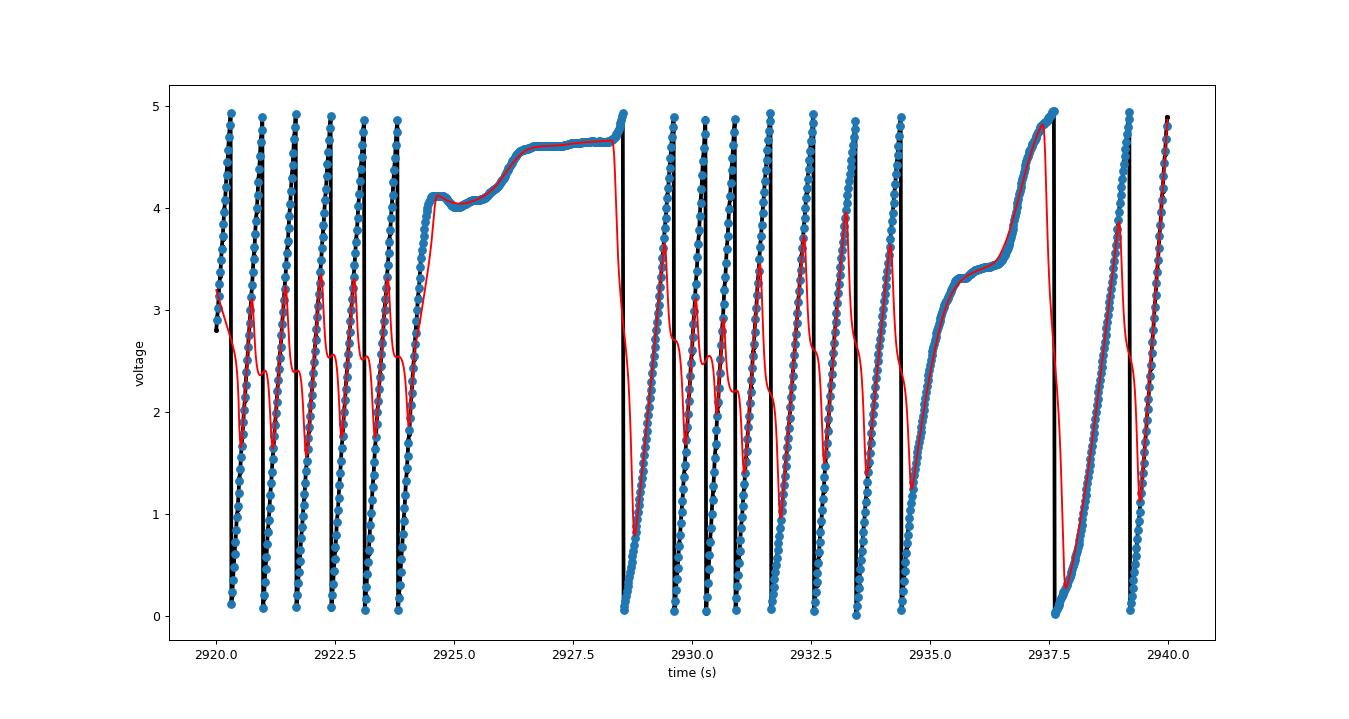

/home/dougo/.conda/envs/visual_behavior/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


In [181]:
# df_sample = running_df_cleaned.query('time>=2922.75 and time <=2925')[['time','v_sig']].copy()
# df_sample = running_df_cleaned.query('time>=2922 and time <=2932')[['time','v_sig']].copy()
# extra_cols = ['estimate_{}'.format(i) for i in range(7)]
# for col in extra_cols:
#     df_sample[col] = np.nan
    
# df_sample = running_df_cleaned.query('time>=2923.3 and time <=2923.6').copy()
fig,ax=plt.subplots(figsize=(15,8))
ax.plot(
    df_sample['time'],
    df_sample['v_sig'],
    marker='.',
    color='black',
    linewidth=3
)

ax.set_xlabel('time (s)')
ax.set_ylabel('voltage')

from sklearn import linear_model
regr = linear_model.LinearRegression()


for index in df_sample.index[4:-4]:
    t_local = df_sample.loc[index-3:index+3]['time'].values
    v_local = df_sample.loc[index-3:index+3]['v_sig']
    regr.fit(t_local.reshape(-1, 1), v_local)

    # Make predictions using the testing set
    v_sig_pred = regr.predict(t_local.reshape(-1, 1))

#     ax.plot(t_local,v_sig_pred)
    
    for ii,idx in enumerate(range(index-3,index+4)):
        df_sample.at[idx,'estimate_{}'.format(ii)] = v_sig_pred[ii]
        
def get_estimate(row, max_estimate_deviance = 0.1):
    return np.nanmedian([row['estimate_{}'.format(i)] if np.abs(row['v_sig'] - row['estimate_{}'.format(i)]) < max_estimate_deviance else np.nan for i in range(7)])
df_sample['v_sig_estimate'] = df_sample.apply(get_estimate, axis=1)

ax.plot(
    df_sample['time'],
    df_sample['v_sig_estimate'],
    marker='o',
    linestyle='none'
)

import statsmodels.api as sm
lowess = sm.nonparametric.lowess(df_sample['v_sig'].values, df_sample['time'].values, frac=.05)

from scipy.interpolate import interp1d

lowess_x = list(zip(*lowess))[0]
lowess_y = list(zip(*lowess))[1]
f = interp1d(lowess_x, lowess_y, bounds_error=False)

xnew = df_sample['time'].values
ynew = f(xnew)

df_sample['v_sig_lowess'] = f(df_sample['time'])

ax.plot(
    xnew,
    ynew,
    color='red'
)

<IPython.core.display.Javascript object>


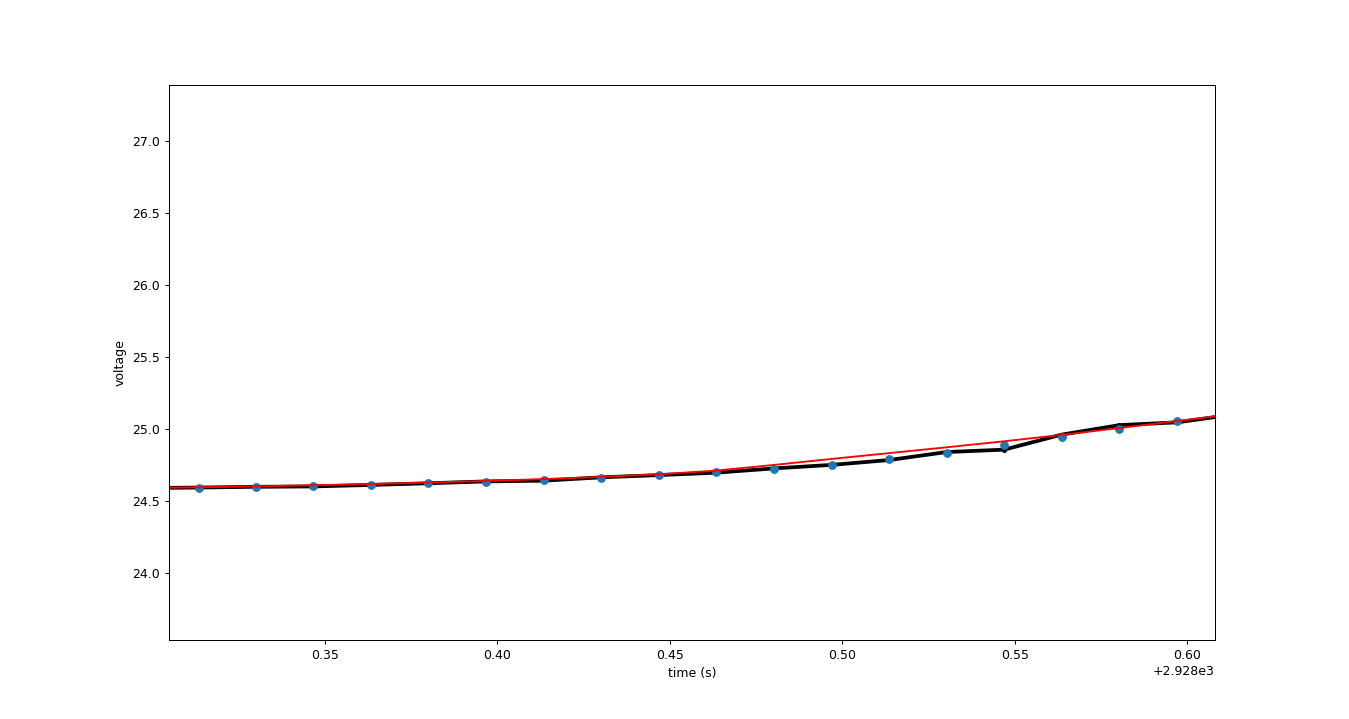

/home/dougo/.conda/envs/visual_behavior/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


In [166]:
fig,ax=plt.subplots(figsize=(15,8))
ax.plot(
    df_sample['time'],
    df_sample['v_sig_unwrapped'],
    marker='.',
    color='black',
    linewidth=3
)

ax.set_xlabel('time (s)')
ax.set_ylabel('voltage')

from sklearn import linear_model
regr = linear_model.LinearRegression()


for index in df_sample.index[4:-4]:
    t_local = df_sample.loc[index-3:index+3]['time'].values
    v_local = df_sample.loc[index-3:index+3]['v_sig_unwrapped']
    regr.fit(t_local.reshape(-1, 1), v_local)

    # Make predictions using the testing set
    v_sig_pred = regr.predict(t_local.reshape(-1, 1))

#     ax.plot(t_local,v_sig_pred)
    
    for ii,idx in enumerate(range(index-3,index+4)):
        df_sample.at[idx,'estimate_{}'.format(ii)] = v_sig_pred[ii]
        
def get_estimate(row, max_estimate_deviance = 0.1):
    return np.nanmedian([row['estimate_{}'.format(i)] if np.abs(row['v_sig_unwrapped'] - row['estimate_{}'.format(i)]) < max_estimate_deviance else np.nan for i in range(7)])
df_sample['v_sig_estimate'] = df_sample.apply(get_estimate, axis=1)

ax.plot(
    df_sample['time'],
    df_sample['v_sig_estimate'],
    marker='o',
    linestyle='none'
)

import statsmodels.api as sm
lowess = sm.nonparametric.lowess(df_sample['v_sig_unwrapped'].values, df_sample['time'].values, frac=.025)

from scipy.interpolate import interp1d

lowess_x = list(zip(*lowess))[0]
lowess_y = list(zip(*lowess))[1]
f = interp1d(lowess_x, lowess_y, bounds_error=False)

xnew = df_sample['time'].values
ynew = f(xnew)

df_sample['v_sig_lowess'] = f(df_sample['time'])

ax.plot(
    xnew,
    df_sample['v_sig_lowess'],
    color='red'
)

In [176]:
# df['delta_theta'] = df['v_sig_diff']/df['v_in']*2*np.pi
# df['dt'] = df['time'].diff().shift() # the shift is necessary to realign the time
# df['speed_cm_s_raw'] = df['delta_theta']/df['dt'] * running_radius

wheel_diameter = 6.5 * 2.54  # 6.5" wheel diameter
running_radius = 0.5 * (2.0 * wheel_diameter / 3.0)  # assume the animal runs at 2/3 the distance from the wheel center

df_sample['angular_rate_raw'] = df_sample['v_sig_unwrapped'].diff()/df_sample['time'].shift()*2*np.pi*running_radius
df_sample['angular_rate_estimate'] = df_sample['v_sig_estimate'].diff()/df_sample['time'].shift()*2*np.pi*running_radius
df_sample['angular_rate_lowess'] = df_sample['v_sig_lowess'].diff()/df_sample['time'].shift()*2*np.pi*running_radius

<IPython.core.display.Javascript object>


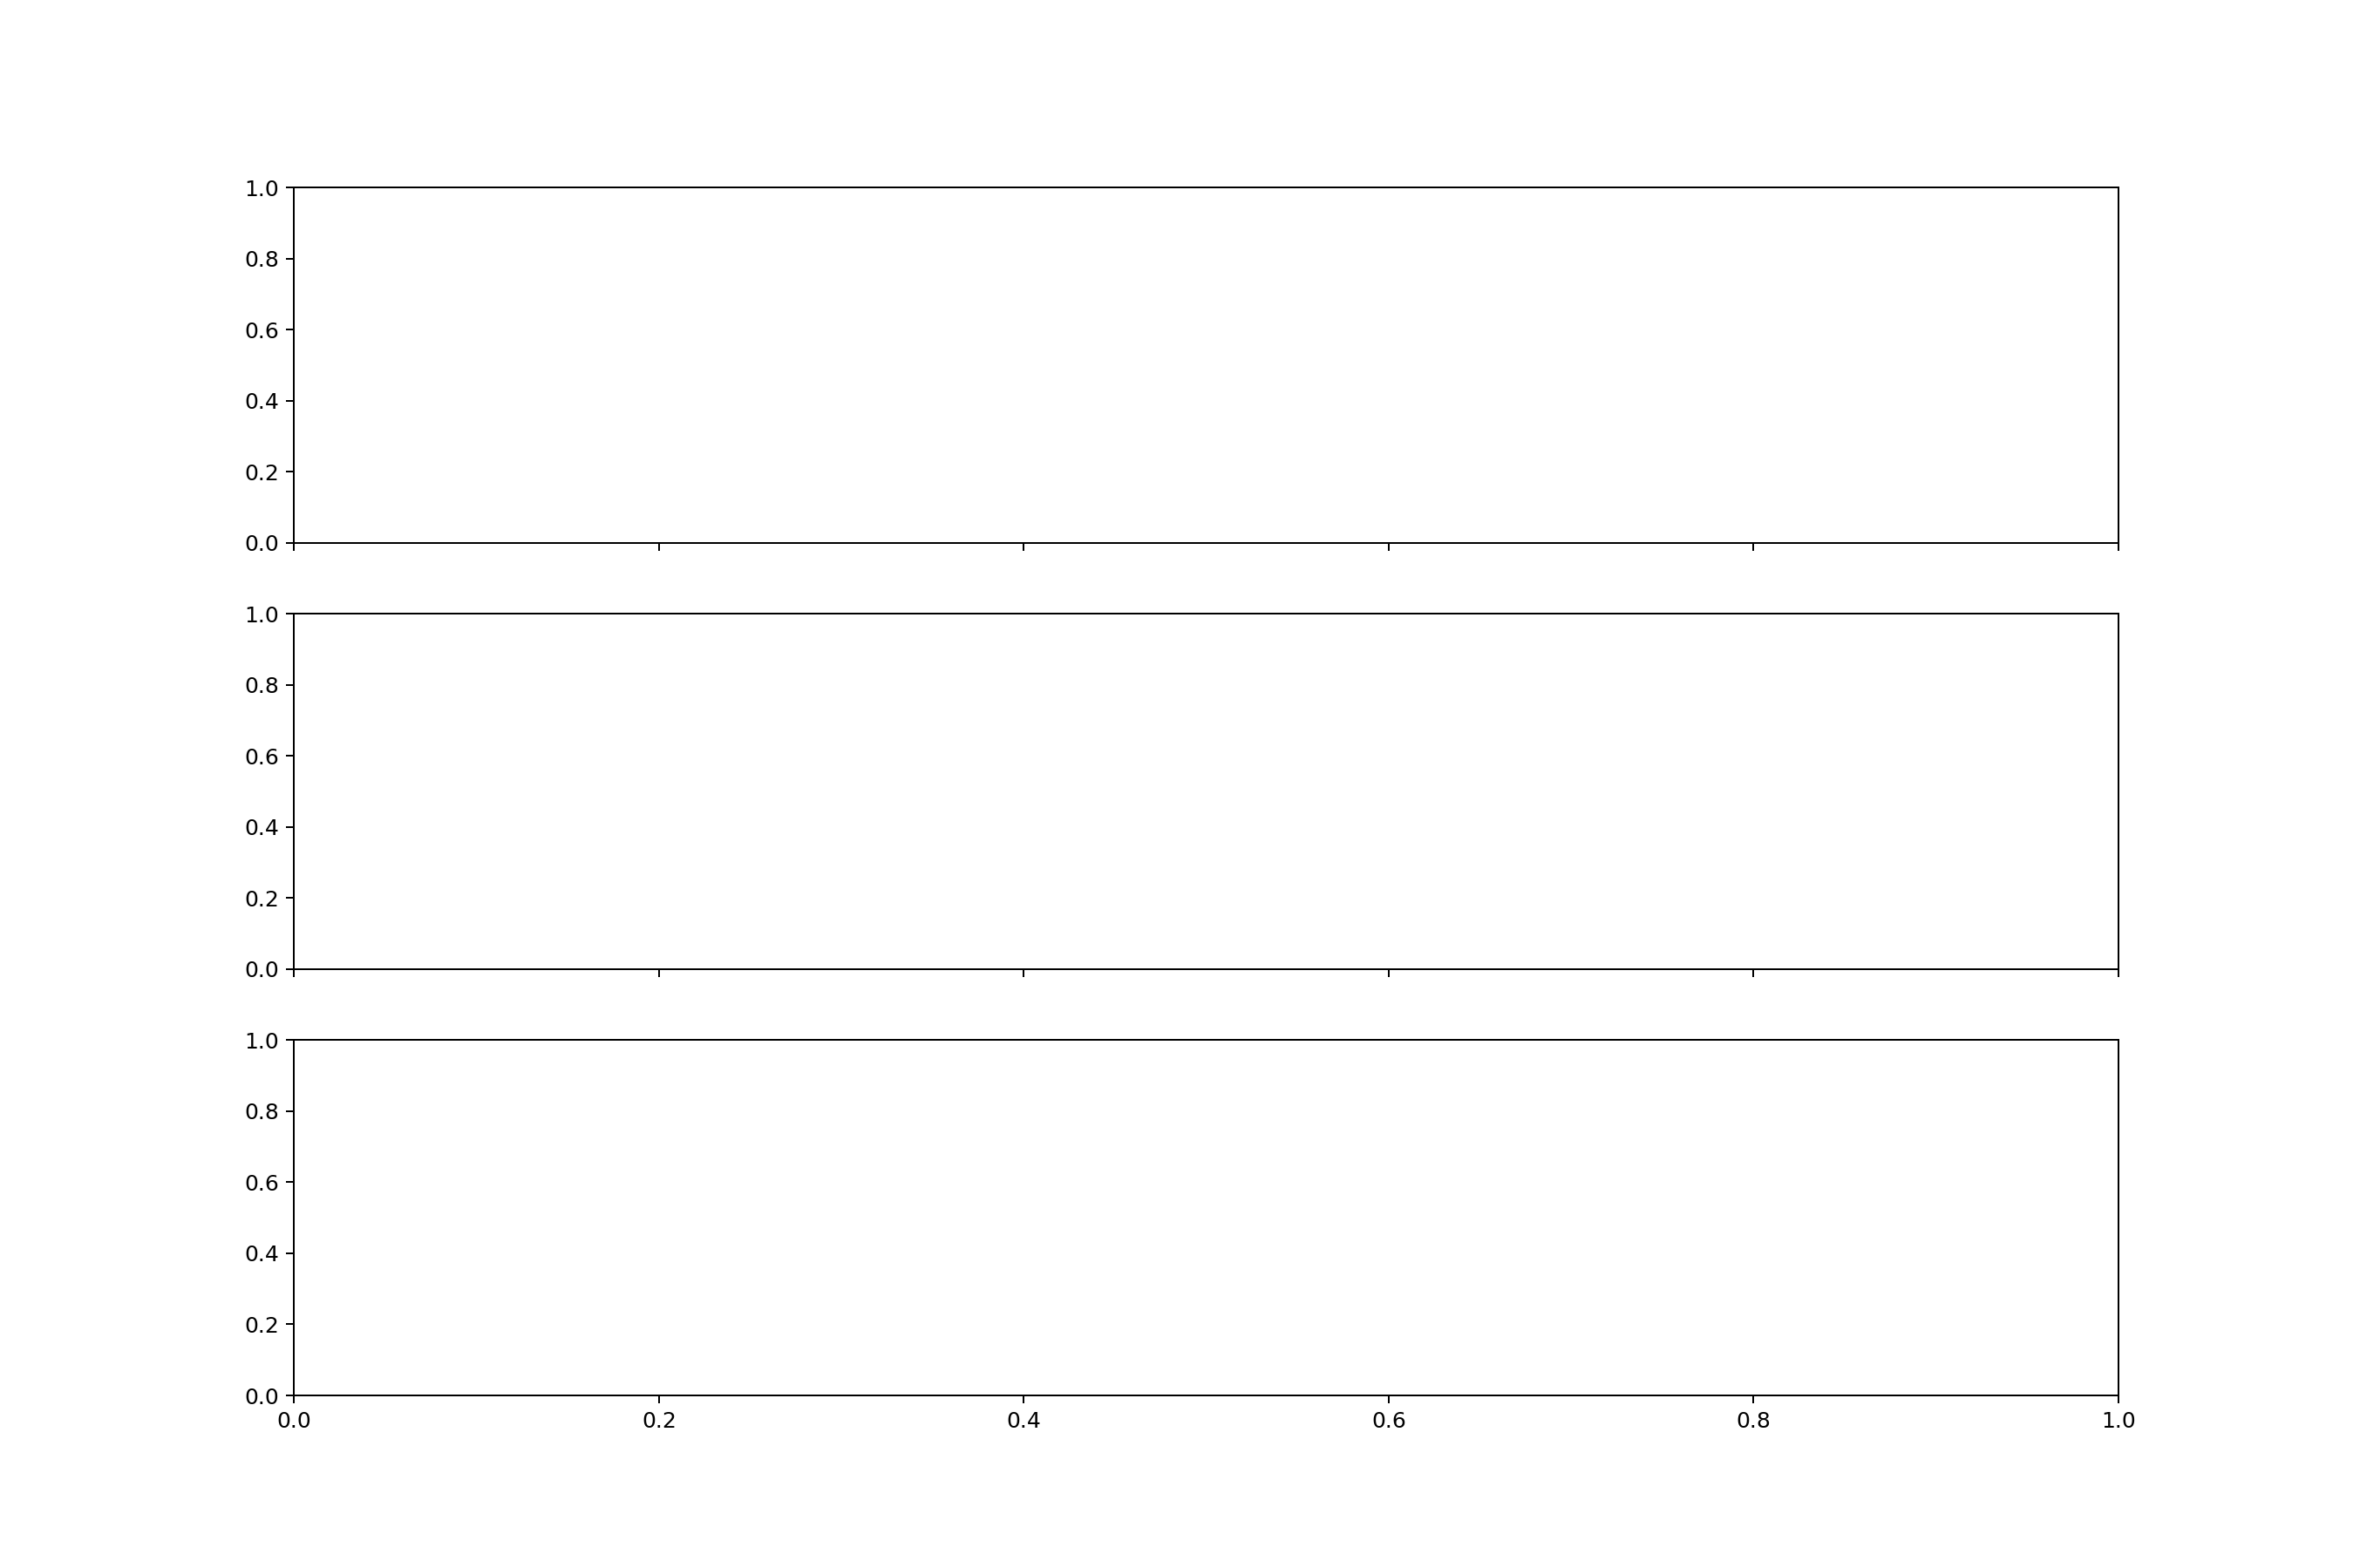

NameError: name 'df_sample' is not defined

In [6]:
fig,ax=plt.subplots(3,1,figsize=(15,10),sharex=True)

ax[0].plot(
    df_sample['time'],
    df_sample['v_sig_unwrapped'],
    marker='.',
    color='black',
    linewidth=3
)

ax[0].plot(
    df_sample['time'],
    df_sample['v_sig_estimate'],
    marker='o',
    linestyle='none'
)

ax[0].plot(
    xnew,
    df_sample['v_sig_lowess'],
    color='red'
)

ax[0].set_ylabel('voltage')

ax[0].legend(['raw (unwrapped)', 'repeated linear regression','lowess estimate'])
ax[0].set_title('voltage (position)')

ax[1].plot(
    df_sample['time'],
    df_sample['angular_rate_raw'],
    color='black'
)

ax[1].plot(
    df_sample['time'],
    df_sample['angular_rate_estimate'],
    color='orange'
)

ax[1].plot(
    df_sample['time'],
    df_sample['angular_rate_lowess'],
    color='green'
)
ax[1].set_title('voltage derivative (speed)')

# lowess = sm.nonparametric.lowess(df_sample['angular_rate_raw'].values, df_sample['time'].values, frac=.03)
lowess = sm.nonparametric.lowess(df_sample['angular_rate_lowess'].values, df_sample['time'].values, frac=.02)

lowess_x = list(zip(*lowess))[0]
lowess_y = list(zip(*lowess))[1]
f = interp1d(lowess_x, lowess_y, bounds_error=False)

xnew = df_sample['time'].values
ynew = f(xnew)

ax[1].plot(
    df_sample['time'],
    f(df_sample['time']),
    color='red'
)

ax[1].legend(['raw (unwrapped)','repeated linear regression','lowess estimate','lowess estimate on lowess estimated angular rate'])


ax[2].set_title('voltage second derivative (acceleration)')
ax[2].set_xlabel('time (s)')

fig.tight_layout()
# ax.set_ylim(-0.01,0.1)

<IPython.core.display.Javascript object>


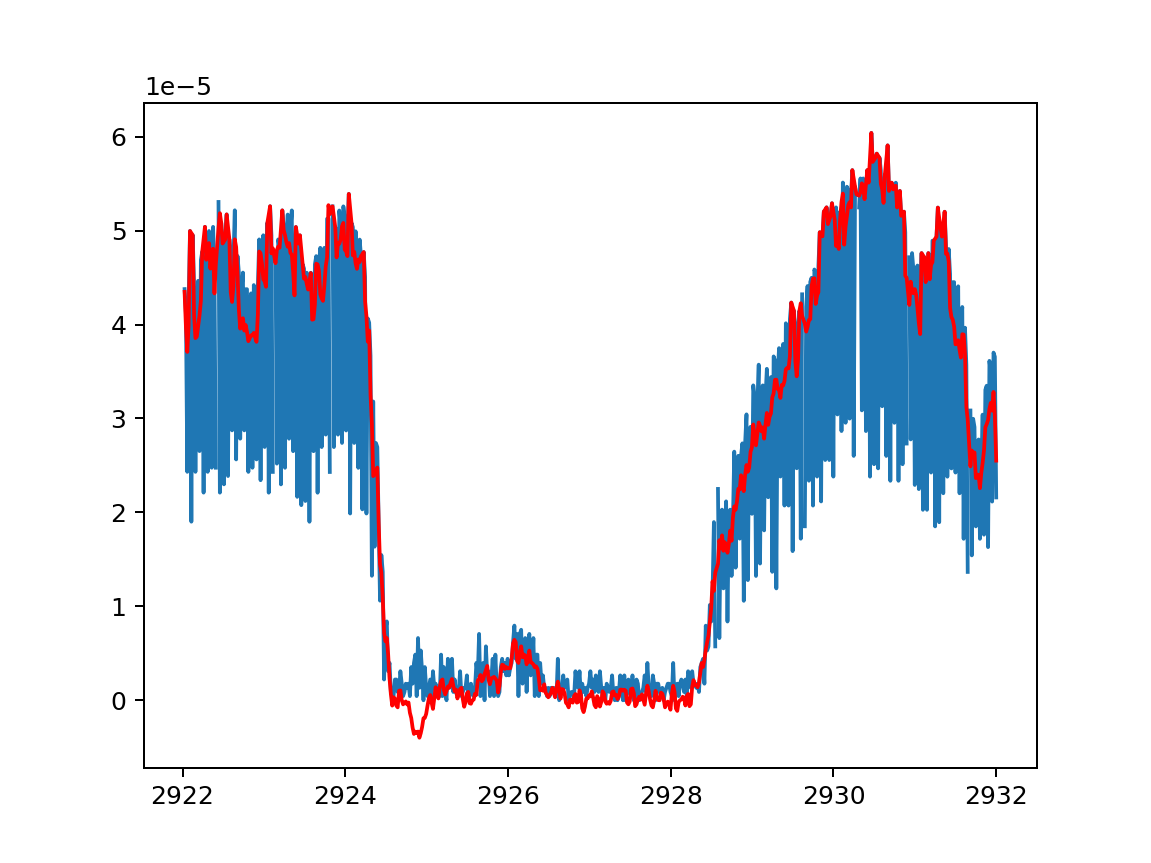

In [87]:
# df_sample = running_df_cleaned.query('time>=2922 and time <=2927')[['time','v_sig']].copy()

df_sample['dvdt'] = df_sample['v_sig'].diff()/df_sample['time'].shift()
df_sample.loc[df_sample['dvdt'][df_sample['dvdt'].abs()>0.0001].index.values,'dvdt'] = np.nan

fig,ax=plt.subplots()
ax.plot(
    df_sample['time'],
    df_sample['dvdt'].abs()
)

lowess = sm.nonparametric.lowess(df_sample['dvdt'].values, df_sample['time'].values, frac=.01)

lowess_x = list(zip(*lowess))[0]
lowess_y = list(zip(*lowess))[1]
f = interp1d(lowess_x, lowess_y, bounds_error=False)

xnew = df_sample['time'].values
ynew = f(xnew)

ax.plot(
    xnew,
    ynew,
    color='red'
)

In [78]:
df_sample['dvdt'][df_sample['dvdt'].abs()>0.0001].index


Int64Index([], dtype='int64')

In [111]:
df_sample

,time,v_sig,v_in,dv,v_sig_last,wrap_ID,v_sig_diff,v_sig_unwrapped,estimate_0,estimate_1,estimate_2,estimate_3,estimate_4,estimate_5,estimate_6,v_sig_estimate,v_sig_lowess
174714,2922.008193,2.143477,4.989814,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
174715,2922.024993,2.271388,4.985938,0.127911,2.143477,0,0.127911,2.271388,2.268852,NaN,NaN,NaN,NaN,NaN,NaN,2.268852,2.271388
174716,2922.041553,2.391546,4.976894,0.120159,2.271388,0,0.120159,2.391546,2.369775,2.376931,NaN,NaN,NaN,NaN,NaN,2.373353,2.375967
174717,2922.058353,2.462608,4.984646,0.071062,2.391546,0,0.071062,2.462608,2.475268,2.483229,2.486578,NaN,NaN,NaN,NaN,2.483229,2.488075
174718,2922.074913,2.586642,4.982062,0.124035,2.462608,0,0.124035,2.586642,2.596677,2.587517,2.595063,2.594657,NaN,NaN,NaN,2.594860,2.586642
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175309,2931.932983,1.294615,4.978186,0.102070,1.192545,0,0.102070,41.178241,NaN,NaN,NaN,41.170127,41.166167,41.162608,41.162301,41.164388,41.178241
175310,2931.949653,1.356632,4.988522,0.062017,1.294615,0,0.062017,41.240258,NaN,NaN,NaN,NaN,41.260155,41.252406,41.248272,41.252406,41.263209
175311,2931.966443,1.465162,4.985938,0.108530,1.356632,0,0.108530,41.348788,NaN,NaN,NaN,NaN,NaN,41.350831,41.339265,41.345048,41.348788
175312,2931.983013,1.572401,4.978186,0.107238,1.465162,0,0.107238,41.456027,NaN,NaN,NaN,NaN,NaN,NaN,41.440319,41.440319,41.433475


In [194]:
max_estimate_deviance = 0.1
np.median([row['estimate_{}'.format(i)] if np.abs(row['v_sig'] - row['estimate_{}'.format(i)]) < max_estimate_deviance else np.nan for i in range(7)])

3.3240257142279006

In [181]:
for ii,idx in enumerate(range(index-3,index+4)):
    df_sample.at[idx,'estimate_{}'.format(ii)] = v_sig_pred[ii]

In [197]:
np.nanmedian([1,2,3,np.nan])

2.0